In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(97)

In [2]:
# Load the data
with open("cnn_outputs.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["train_outputs"]
y_train = data["train_labels"]
X_valid = data["valid_outputs"]
y_valid = data["valid_labels"]

In [3]:
# 1. Determine and visualize the distribution of the data

def analyze_distribution(X, y, title):
    plt.figure(figsize=(15, 5))
    for i in range(X.shape[1]):
        plt.subplot(1, 3, i+1)
        for class_label in np.unique(y):
            sns.histplot(X[y == class_label, i], kde=True, label=f'Class {class_label}')
        plt.title(f'Distribution of Feature {i+1} by Class')
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    for i in range(X.shape[1]):
        _, p_value = stats.normaltest(X[:, i])
        print(f"Feature {i+1} normality test p-value: {p_value}")

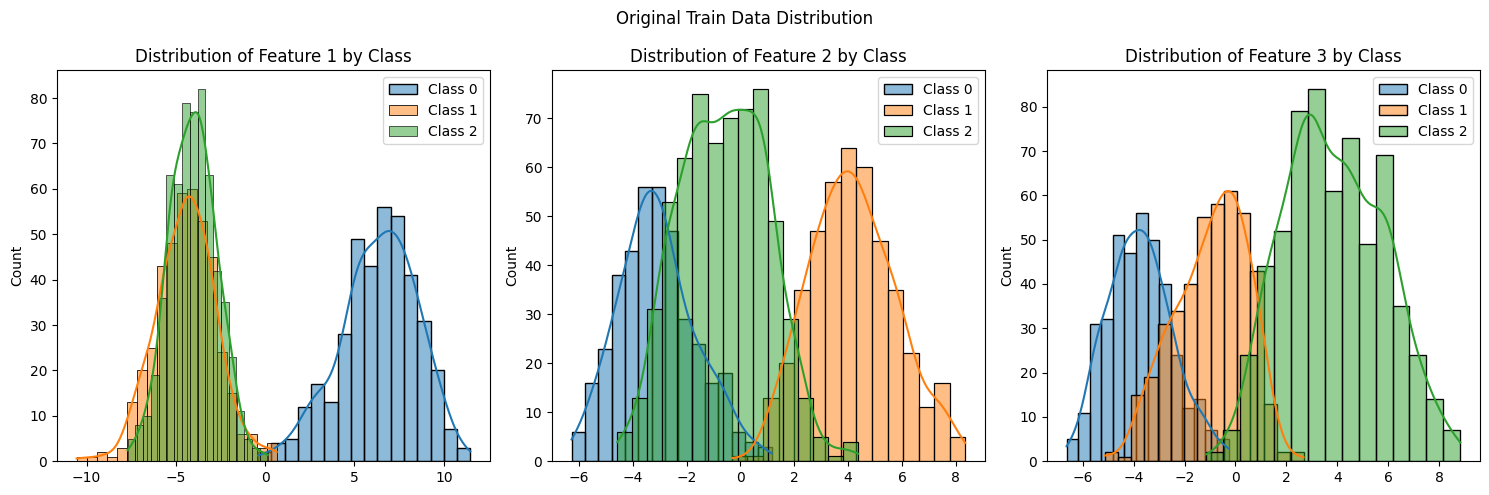

Feature 1 normality test p-value: 3.8677182497287154e-43
Feature 2 normality test p-value: 5.319630692783631e-32
Feature 3 normality test p-value: 3.089223423996311e-72


In [4]:
analyze_distribution(X_train, y_train, "Original Train Data Distribution")

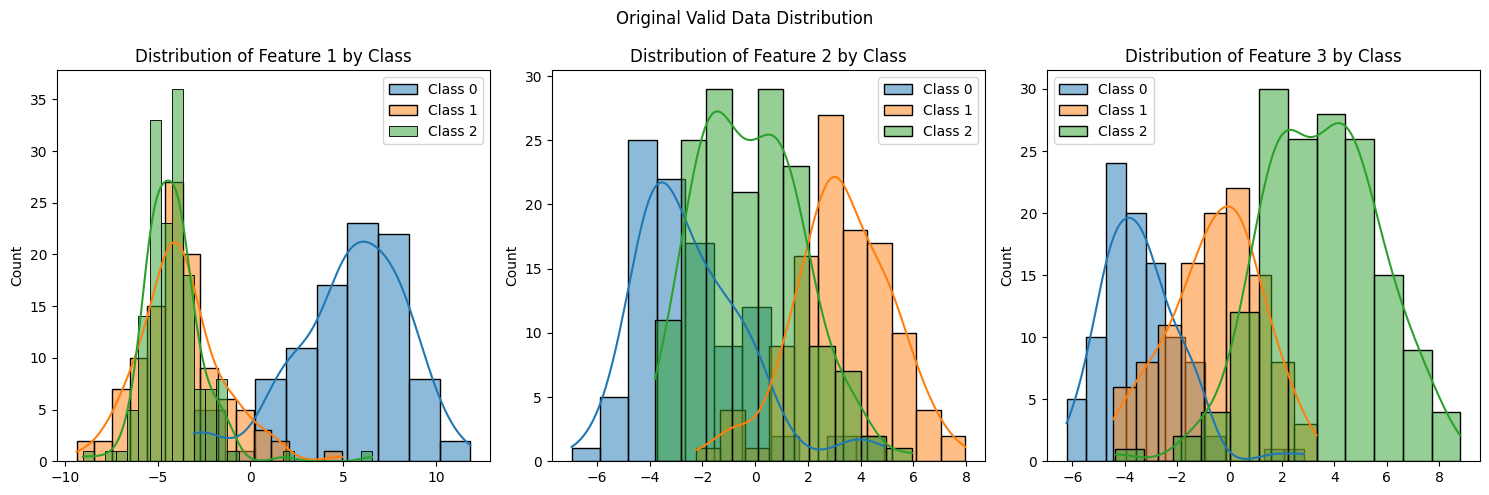

Feature 1 normality test p-value: 5.240841084173257e-11
Feature 2 normality test p-value: 3.1015903189203457e-06
Feature 3 normality test p-value: 2.2102671607339835e-10


In [5]:
analyze_distribution(X_valid, y_valid, "Original Valid Data Distribution")

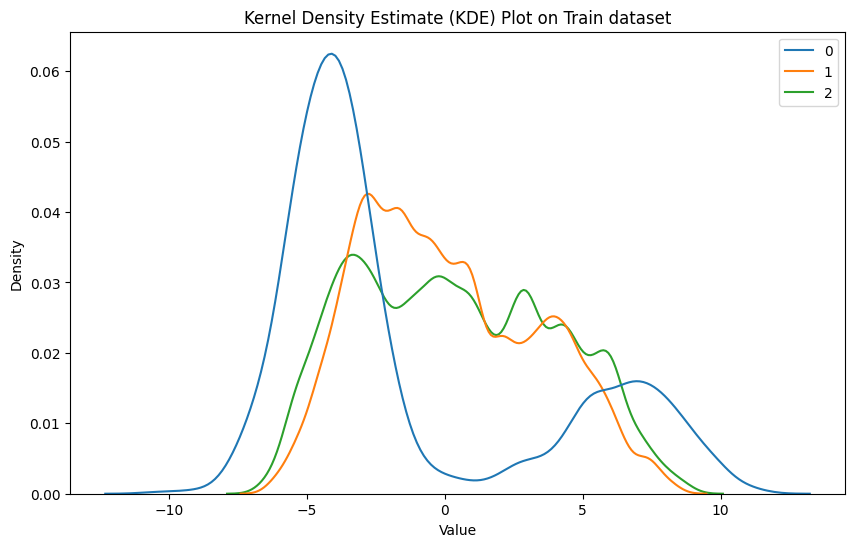

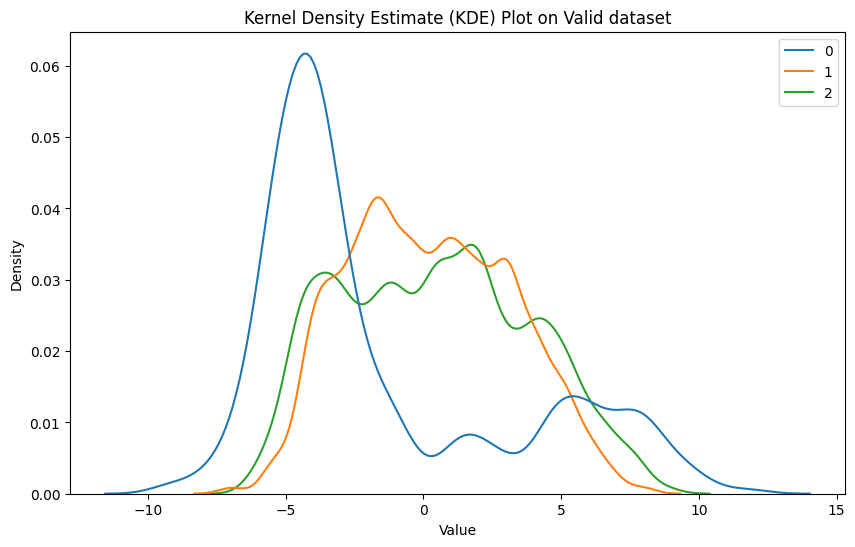

In [6]:
# Vẽ KDE plot
data = X_train
plt.figure(figsize=(10, 6))
sns.kdeplot(data, bw_adjust=0.5)
plt.title('Kernel Density Estimate (KDE) Plot on Train dataset')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()
data = X_valid
plt.figure(figsize=(10, 6))
sns.kdeplot(data, bw_adjust=0.5)
plt.title('Kernel Density Estimate (KDE) Plot on Valid dataset')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

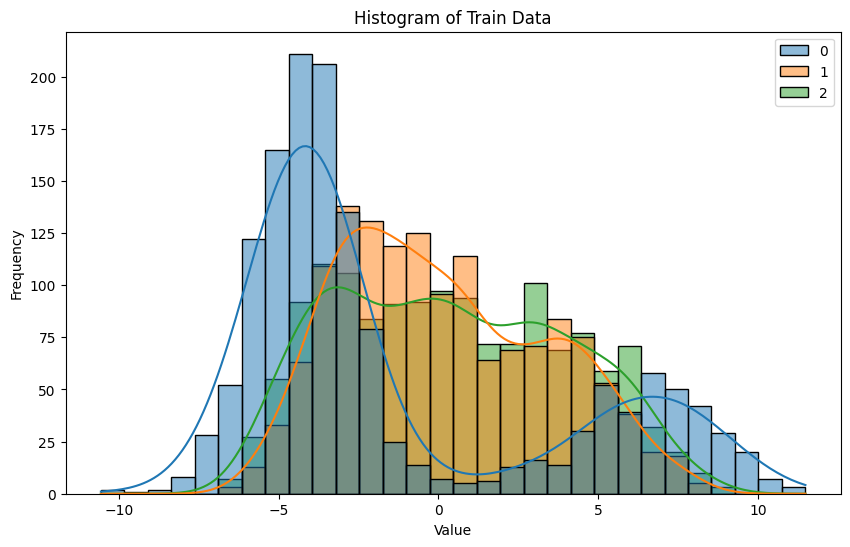

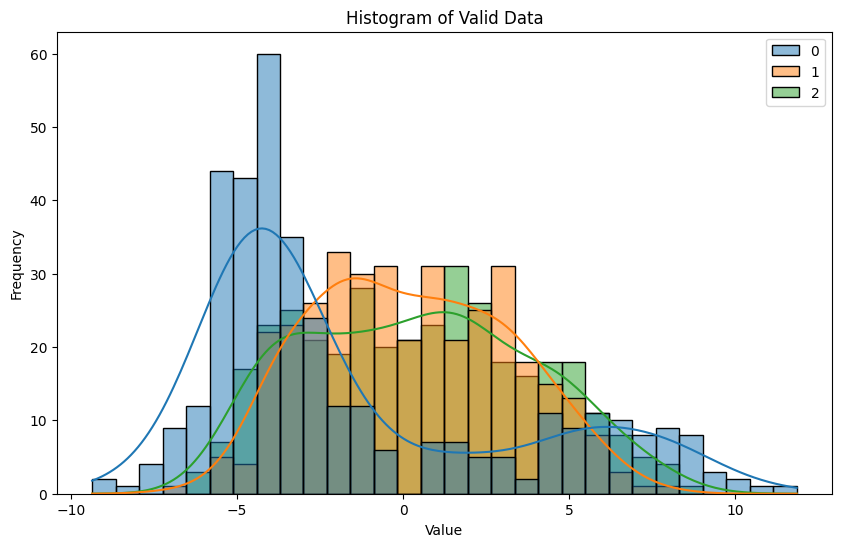

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = X_train[:, :]
# Vẽ histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30)
plt.title('Histogram of Train Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
data = X_valid[:, :]
# Vẽ histogram
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=30)
plt.title('Histogram of Valid Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

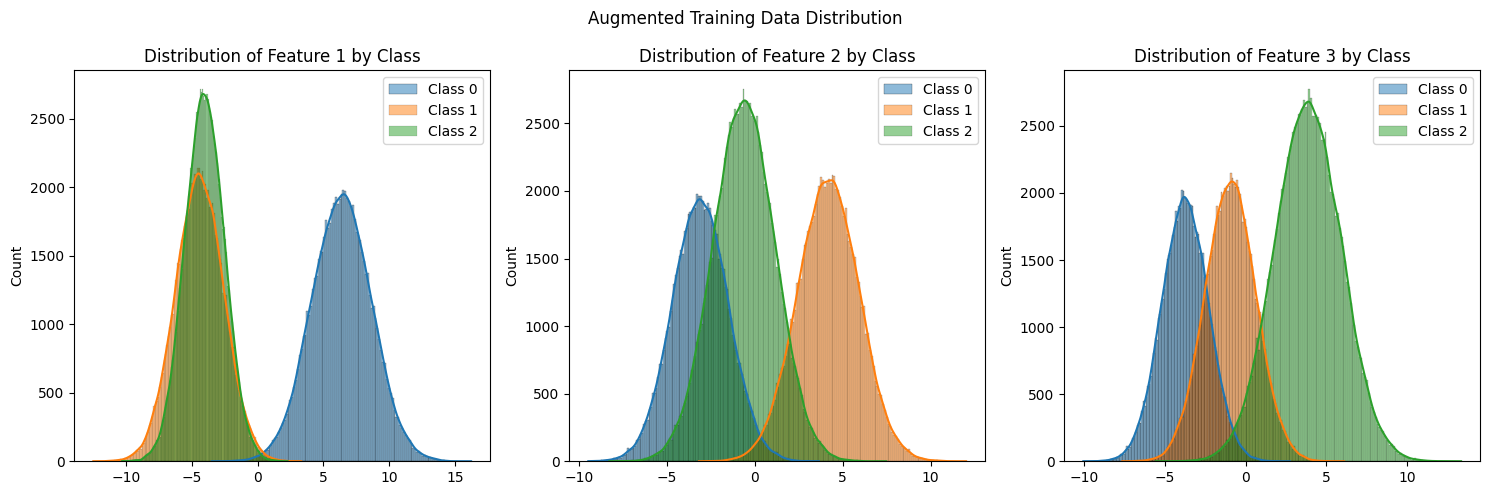

Feature 1 normality test p-value: 0.0
Feature 2 normality test p-value: 0.0
Feature 3 normality test p-value: 0.0


In [8]:
# 2. Create more data based on the distribution (only for training set)


def create_more_data(X, y, multiplier=2):
    new_X = []
    new_y = []
    for class_label in np.unique(y):
        class_X = X[y == class_label]
        class_mean = np.mean(class_X, axis=0)
        class_cov = np.cov(class_X.T) + 0.5

        new_samples = stats.multivariate_normal.rvs(
            mean=class_mean, cov=class_cov, size=class_X.shape[0] * (multiplier - 1)
        )
        new_X.append(np.vstack((class_X, new_samples)))
        new_y.extend([class_label] * (class_X.shape[0] * multiplier))

    return np.vstack(new_X), np.array(new_y)


# X_train_augmented, y_train_augmented = create_more_data(X_train, y_train, multiplier=200)
X_train_augmented, y_train_augmented = create_more_data(X_train, y_train, multiplier=200)

analyze_distribution(
    X_train_augmented, y_train_augmented, "Augmented Training Data Distribution"
)

In [29]:
# 3. Prepare data for training

batch_size = 32
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_train_aug_scaled = scaler.fit_transform(X_train_augmented)


# X_train_scaled = X_train
# X_valid_scaled = X_valid
# X_train_aug_scaled = X_train_augmented

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_valid_tensor = torch.FloatTensor(X_valid_scaled)
y_valid_tensor = torch.LongTensor(y_valid)

X_train_aug_tensor = torch.FloatTensor(X_train_aug_scaled)
y_train_aug_tensor = torch.LongTensor(y_train_augmented)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_aug_dataset = TensorDataset(X_train_aug_tensor, y_train_aug_tensor)
train_aug_loader = DataLoader(train_aug_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Tính toán số lượng mẫu cho mỗi lớp
class_counts = np.zeros(len(np.unique(y_train_tensor.numpy())))

for _, labels in train_loader:
    labels = labels.numpy()
    for label in np.unique(labels):
        class_counts[label] += np.sum(labels == label)

# Tính trọng số cho từng lớp
total_samples = np.sum(class_counts)
weights = total_samples / (len(class_counts) * class_counts)

# Chuyển đổi trọng số thành tensor
weights_tensor = torch.tensor(weights, dtype=torch.float32)

print('Class counts:', class_counts)
print('Weights:', weights_tensor)

Class counts: [385. 432. 624.]
Weights: tensor([1.2476, 1.1119, 0.7698])


In [11]:
class_counts = np.zeros(len(np.unique(y_train_aug_tensor.numpy())))

for _, labels in train_aug_loader:
    labels = labels.numpy()
    for label in np.unique(labels):
        class_counts[label] += np.sum(labels == label)

# Tính trọng số cho từng lớp
total_samples = np.sum(class_counts)
weights_aug = total_samples / (len(class_counts) * class_counts)

# Chuyển đổi trọng số thành tensor
weights_tensor_aug = torch.tensor(weights, dtype=torch.float32)

print('Class counts:', class_counts)
print('Weights:', weights_tensor_aug)

Class counts: [ 77000.  86400. 124800.]
Weights: tensor([1.2476, 1.1119, 0.7698])


In [34]:
# # 4. Define the model


# class H97_ANN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(H97_ANN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.fc4 = nn.Linear(hidden_size, num_classes)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.sigmoid(x)
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.dropout(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.dropout(out)
#         out = self.fc3(out)
#         out = self.relu(out)
#         out = self.dropout(out)
#         out = self.fc4(out)
#         return out

import torch
import torch.nn as nn

class H97_ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(H97_ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.softmax = nn.Softmax(dim=1)

        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize weights with a standard normal distribution
        for layer in self.children():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.batch_norm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        # out = self.softmax(out)  # Apply softmax for multi-class classification
        
        return out


In [30]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5. Train the model with early stopping
def train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=10, model_name="best_model_H97_ANN.pth"
):
    model.to(device)
    train_losses = []
    valid_losses = []
    best_valid_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}"
        )

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_name)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            model.load_state_dict(torch.load(model_name, weights_only=True))
            break

    return model, train_losses, valid_losses

In [31]:

# 6. Train and evaluate models
def train_and_evaluate(X_train, y_train, X_valid, y_valid, title):
    model = H97_ANN(X_train.shape[1], 97, len(np.unique(y_train)))
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = optim.Adam(model.parameters())
    model.to(device)
    criterion.to(device)

    train_dataset = TensorDataset(torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
    train_loader = DataLoader(train_dataset, batch_size=120, shuffle=True)
    valid_dataset = TensorDataset(torch.FloatTensor(X_valid).to(device), torch.LongTensor(y_valid).to(device))
    valid_loader = DataLoader(valid_dataset, batch_size=120, shuffle=False)

    model, train_losses, valid_losses = train_model(model, train_loader, valid_loader, criterion, optimizer, model_name=f"best_model_H97_ANN_{title}.pth")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        X_valid_tensor = torch.FloatTensor(X_valid).to(device)
        y_valid_tensor = torch.LongTensor(y_valid).to(device)
        valid_outputs = model(X_valid_tensor)
        _, predicted = torch.max(valid_outputs.data, 1)
        accuracy = (predicted == y_valid_tensor).float().mean()

    print(f"{title} - Validation accuracy: {accuracy:.4f}")

    # Visualize predictions
    y_pred = nn.Softmax(dim=1)(valid_outputs).cpu().numpy()
    plt.figure(figsize=(10, 8))
    for i in range(3):
        for j in range(3):
            if i != j:
                plt.subplot(3, 3, i*3 + j + 1)
                scatter = plt.scatter(y_pred[:, i], y_pred[:, j], c=y_valid, cmap='viridis', alpha=0.5)
                plt.xlabel(f'Class {i} probability')
                plt.ylabel(f'Class {j} probability')
    plt.colorbar(scatter)
    plt.suptitle(f'{title} - Prediction Probabilities')
    plt.tight_layout()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/100, Train Loss: 1.0940, Valid Loss: 1.0560
Epoch 2/100, Train Loss: 1.0092, Valid Loss: 0.9218
Epoch 3/100, Train Loss: 0.8278, Valid Loss: 0.6929
Epoch 4/100, Train Loss: 0.6290, Valid Loss: 0.4729
Epoch 5/100, Train Loss: 0.4031, Valid Loss: 0.3830
Epoch 6/100, Train Loss: 0.4243, Valid Loss: 0.3194
Epoch 7/100, Train Loss: 0.2566, Valid Loss: 0.3178
Epoch 8/100, Train Loss: 0.3014, Valid Loss: 0.3111
Epoch 9/100, Train Loss: 0.2209, Valid Loss: 0.3198
Epoch 10/100, Train Loss: 0.2532, Valid Loss: 0.3025
Epoch 11/100, Train Loss: 0.2148, Valid Loss: 0.3182
Epoch 12/100, Train Loss: 0.3571, Valid Loss: 0.3149
Epoch 13/100, Train Loss: 0.1968, Valid Loss: 0.3582
Epoch 14/100, Train Loss: 0.1856, Valid Loss: 0.3106
Epoch 15/100, Train Loss: 0.1731, Valid Loss: 0.3138
Epoch 16/100, Train Loss: 0.2741, Valid Loss: 0.3207
Epoch 17/100, Train Loss: 0.1720, Valid Loss: 0.3195
Epoch 18/100, Train Loss: 0.1668, Valid Loss: 0.3300
Epoch 19/100, Train Loss: 0.1561, Valid Loss: 0.3304
Ep

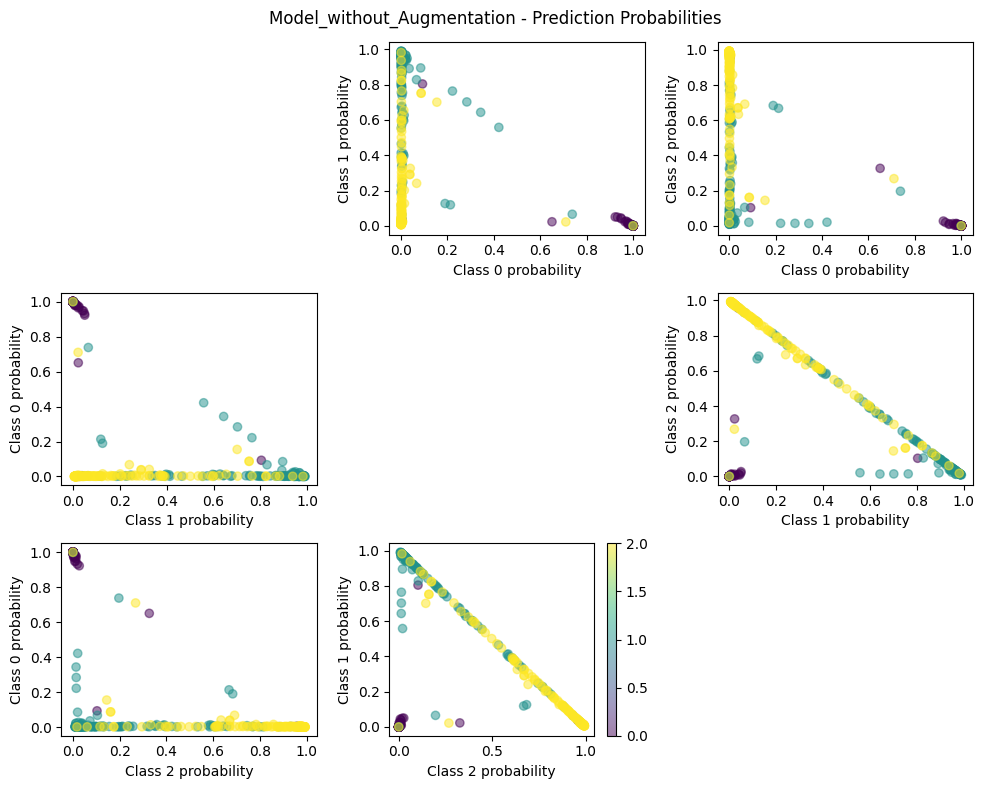

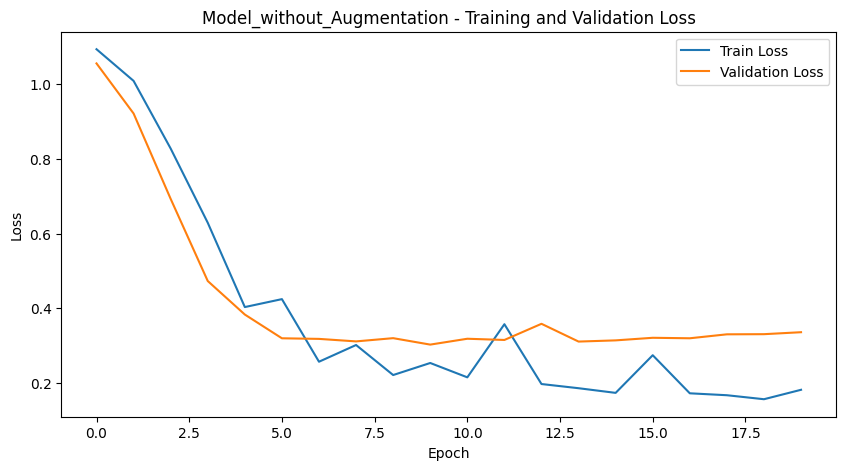

In [32]:
# Train and evaluate model without augmentation
train_and_evaluate(X_train_scaled, y_train, X_valid_scaled, y_valid, "Model_without_Augmentation")

Epoch 1/100, Train Loss: 0.1411, Valid Loss: 0.4490
Epoch 2/100, Train Loss: 0.1096, Valid Loss: 0.5285
Epoch 3/100, Train Loss: 0.1075, Valid Loss: 0.5134
Epoch 4/100, Train Loss: 0.1063, Valid Loss: 0.5662
Epoch 5/100, Train Loss: 0.1061, Valid Loss: 0.5413
Epoch 6/100, Train Loss: 0.1055, Valid Loss: 0.5841
Epoch 7/100, Train Loss: 0.1054, Valid Loss: 0.6076
Epoch 8/100, Train Loss: 0.1051, Valid Loss: 0.6129
Epoch 9/100, Train Loss: 0.1045, Valid Loss: 0.5439
Epoch 10/100, Train Loss: 0.1046, Valid Loss: 0.6328
Epoch 11/100, Train Loss: 0.1045, Valid Loss: 0.6066
Early stopping!
Model_with_Augmentation - Validation accuracy: 0.8705


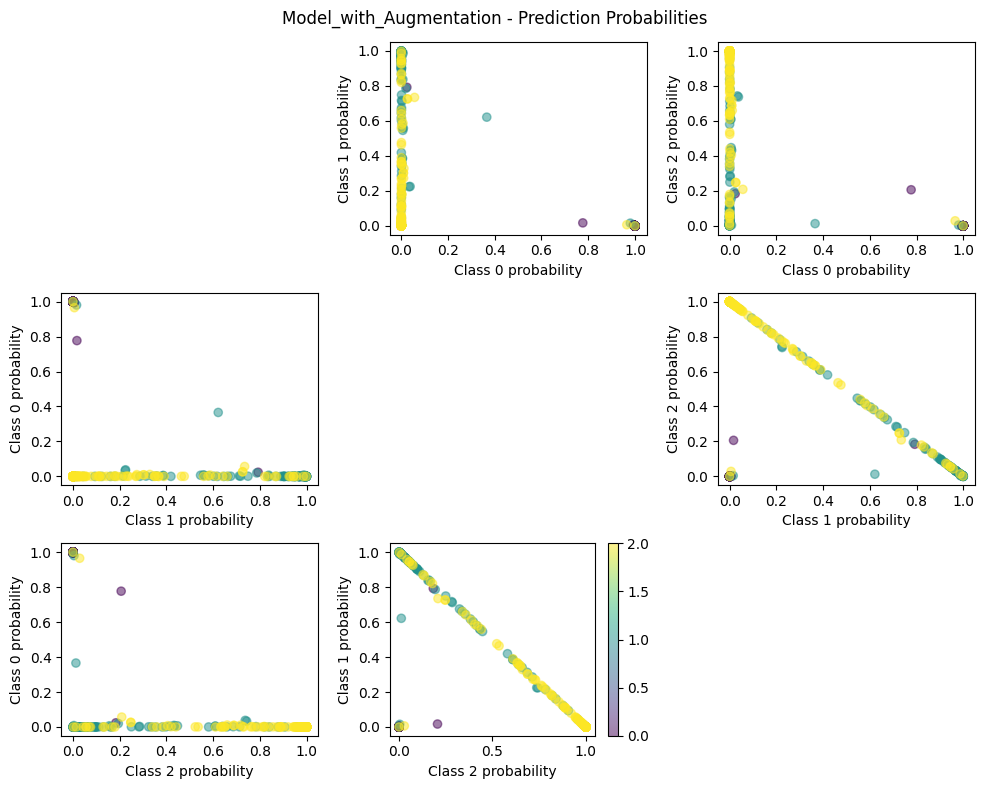

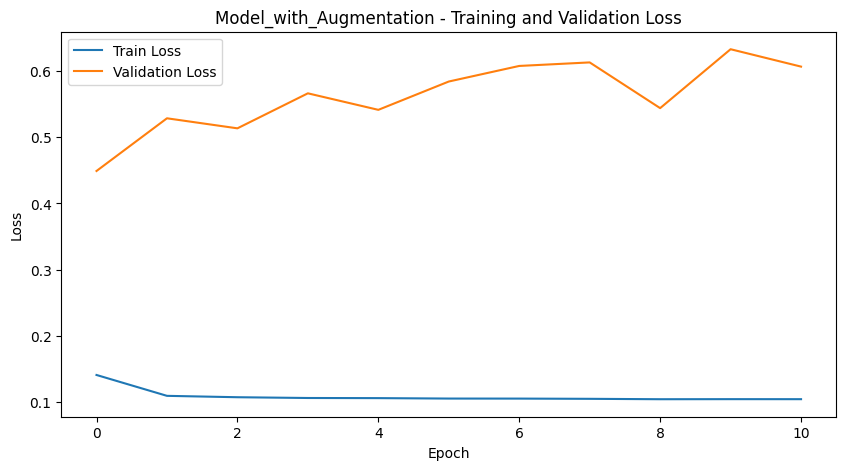

In [33]:
# Train and evaluate model with augmentation
train_and_evaluate(X_train_aug_scaled, y_train_augmented, X_valid_scaled, y_valid, "Model_with_Augmentation")

In [35]:
# Train and evaluate model without augmentation
train_and_evaluate(X_train_scaled, y_train, X_valid_scaled, y_valid, "Model_without_Augmentation")

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 97])